In [59]:
from qiskit import *
import numpy as np
from numpy import pi
from qiskit.tools.visualization import plot_bloch_multivector, plot_histogram
import matplotlib
import matplotlib.pyplot as plt
from qiskit.aqua.operators import Z, One, Zero

%matplotlib inline

-1.0
0.9999999999999999
-0.9999999999999998
1.0
-0.9999999999999997
0.9999999999999999
-0.9999999999999999
0.9999999999999998
-1.0
0.9999999999999999
-1.0
0.9999999999999998
-0.9999999999999998
0.9999999999999999
-0.9999999999999998
-1.0
1.0
0.9999999999999999
-0.9999999999999998
1.0000000000000002
-0.9999999999999999
[{'111': 1}, {'000': 1}, {'111': 1}, {'000': 1}, {'111': 1}, {'000': 1}, {'111': 1}, {'001': 1}, {'111': 1}, {'000': 1}, {'111': 1}, {'010': 1}, {'110': 1}, {'000': 1}, {'111': 1}, {'100': 1}, {'010': 1}, {'010': 1}, {'101': 1}, {'010': 1}, {'111': 1}]


C:\Users\Paul\Anaconda3\envs\qc\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


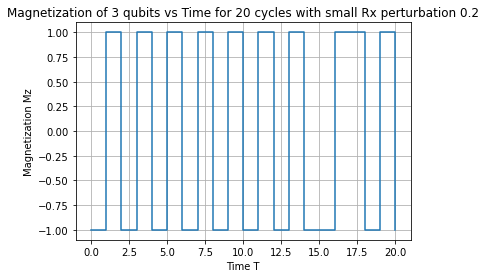

In [58]:
def DTC (qubits,steps,perturbation):
    """ Builds a discrete time crystal with small Rx perturbation. Can input N qubits, number of trotter steps and x rotation angle """
    
    qc = QuantumCircuit(qubits,qubits)
    
    total_counts = [] #Empty list for counting
    Mz = [] #Empty list for Magnetization
    
    def Z_N_qubit_operator(qubits):       
        """ Determines the Z operator for N qubits """
        
        z = np.matrix([[1, 0], [0, -1]])
        x = np.matrix([[0,1],[1,0]])
        identity = np.matrix([[1, 0], [0, 1]])
        
        for i in range(qubits-1): #Users tensor product of Z and identity matrices to build appropriate Z operator
            
            if i < 1:
                
                operator = np.kron(z,identity) 
            elif i is qubits:
                break
            else:
                operator = np.kron(operator,identity)
                
        return operator    
    
    N_qubits = list(range(qubits))

    N_qubits = [N_qubits[i:i + 2] for i in range(0, len(N_qubits)-1, 1)] #Creates a list of list of 2 qubits to couple with z rotations

    def expectation(operator,statevector):
        """ Calculates the expectation value using an operator and statevector """
    
        state = np.matrix(statevector).getT() 
        #print(state)
    
        state_conj_tran = state.getH() #Transpose conjugate
            
        expectation_value = np.dot(state_conj_tran,(np.dot(operator,state)))    #<psi|operator|psi>
        print(expectation_value.real[0,0])
        Mz.append(expectation_value[0,0])
        
    for i in range(steps):  #Adds the X, controlled z rotations, controlled x perturbation rotations
        
        qc.x(range(qubits))
        
        for j in range(len(N_qubits)):
            
            qc.crz(np.random.uniform(2*pi,0),N_qubits[j][0],N_qubits[j][1])
        
        for j in range(qubits):
        
            #qc.rx(np.random.uniform(0.5,0),j)
            qc.rx(perturbation,j)
            
        qc.barrier()            
        qc.measure(range(qubits),range(qubits))
        
        backend = Aer.get_backend('statevector_simulator') #obtains intermediate statevectors
        result = execute(qc, backend = backend).result()
        counts = result.get_counts()
        total_counts.append(counts)
        
        statevector = result.get_statevector()
        #print(statevector)
        expectation(Z_N_qubit_operator(qubits),statevector)
        
        qc.barrier()
              
    qc.z(range(qubits))
    qc.x(range(qubits))
    
    for k in range(qubits-1):
            
        qc.crz(np.random.uniform(2*pi,0),N_qubits[k][0],N_qubits[k][1])

    for j in range(qubits):
        
        #qc.rx(np.random.uniform(0.5,0),j)
        qc.rx(perturbation,j)
    
    qc.barrier()
    qc.measure(range(qubits),range(qubits))
    
    backend = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend = backend).result()
    counts = result.get_counts()
    total_counts.append(counts)
    
    statevector = result.get_statevector()
    #print(statevector)
    expectation(Z_N_qubit_operator(qubits),statevector)
    
    print(total_counts)

    t = np.arange(0,steps+1,1)
    
    fig, ax = plt.subplots()
    ax.step(t, Mz,where='post')

    ax.set(xlabel='Time T', ylabel='Magnetization Mz')
    ax.set_title(f'Magnetization of {qubits} qubits vs Time for {steps} cycles with small Rx perturbation {perturbation}')
    ax.grid()

    plt.show()
    #return(qc.draw(output='mpl'))
                    
DTC(3,steps=20,perturbation=0.2)